In [1]:
import transportation_tutorials as tt

# Manipulating Geographic Data

A [shapefile](https://en.wikipedia.org/wiki/Shapefile) is a data format that is actually a set of files
containing geospatial information.  All of the related files have the same filename (except for the file
extension) and must reside in the same directory.  Generally, there will be files with the ``shp`` extension 
containing geographic data, the ``dbf`` extension containing tabular data, and a few others.  The files
can be read into python as a group and manipulated using the [GeoPandas](http://geopandas.org) package.

In [2]:
import geopandas as gpd

## Loading a Shapefile

Let's load the SERPM8 TAZ shapefile.  This shapefile (actually a set of files)
is included in the data of the tuturials package and can be accessed as shown.
Loading a shapefile into Python using geopandas is a simple task using the
[read_file](http://geopandas.org/reference/geopandas.read_file.html) function.

In [3]:
shapefile_filename = tt.data('SERPM8-TAZSHAPE')
taz = gpd.read_file(shapefile_filename)

This will load the shapefile into a 
[GeoDataFrame](http://geopandas.org/reference.html#geodataframe) object, 
which is similar to
a pandas DataFrame, but with a special *geometry* column that contains, 
as you might guess, geometric shape data contained in the *shp* part of 
the shapefile.  It also includes all the other
various tabular data contained in the *dbf* part of the shapefile.  We
can inspect the first few lines of the GeoDataFrame to see the contents,
just like a regular DataFrame:

In [4]:
taz.head()

,OBJECTID,TAZ_REG,TAZ_OLD05,TAZ_MPO,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,1,1122.0,1122,1122,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936374.6744969971 959539.5675094873,..."
1,2,17.0,17,17,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942254.5000076629 952920.9373740703,..."
2,3,1123.0,1123,1123,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((940953.5610084943 952985.0688074902,..."
3,4,1120.0,1120,1120,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06,"POLYGON ((953118.9999321625 951985.3749407381,..."
4,5,1121.0,1121,1121,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07,"POLYGON ((934328.2825924121 951600.5853559896,..."


Because this is the TAZ shapefile, we expect that the geometry column includes a set of 
[Polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) values, as we
can observe in the first few rows.  We can also easily check how many zones are included
in the file by checking the length of the GeoDataFrame.

In [5]:
len(taz)

4236

Displaying the shapefile in a jupyter notebook can be accomplished by calling the 
[plot](http://geopandas.org/reference.html?highlight=plot#geopandas.GeoDataFrame.plot)
method of the GeoDataFrame.

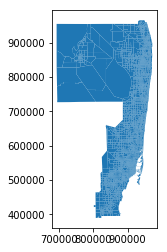

In [6]:
ax = taz.plot()

## Coordinate Reference Systems

You might notice that the axis labels don't show latitude and longitude.
That's because the TAZ file uses a 
different coordinate reference system (*crs*) for map projection.
We can find what crs is being used by accessing the [crs](http://geopandas.org/projections.html#coordinate-reference-systems) attribute.

In [7]:
taz.crs

{'init': 'epsg:2236'}

Drop that code into [Google](http://www.google.com/search?q=epsg%3A2236)
and you'll find that it's a special coordinate system for
[mapping and engineering in eastern Florida](https://spatialreference.org/ref/epsg/nad83-florida-east-ftus/), which for this application may be perfectly reasonable.
However, suppose we want to generate maps using plain old 
latitude and longitude. We can convert between CRS systems
easily, like this:

In [8]:
taz1 = taz.to_crs(epsg=4326)

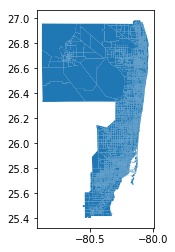

In [9]:
ax = taz1.plot()

The map projection generated here is subtly different from the previous one.  If you look
carefully, you'll note the shape of the second map is a bit wider than first.  This distortion
is a natural part of the mapping projection, using plain latitude and longitude, as one
degree of longitude is a different distance than one degree of latitude.  In Florida, the 
difference is relatively small, but it grows as you move north.

## Selecting by Geography

The SERPM8 region is quite large.  Let's suppose we only want to study a small
portion of this region. Since we are working with Jupyter notebooks, we'll select 
an area to study around Jupiter, Florida. 

### Selection by Rectangular Envelope

We can explicitly define some bounds for
our study area:

In [10]:
xmin = 905712.145924
ymin = 905343.94408855
xmax = 983346.68922847
ymax = 981695.93140023

Then, to select only the TAZ's that are (at least partially) contained in the study area,
we can use the ``cx`` indexer on GeoDataFrames.  This indexer works similarly to the ``loc``
and ``iloc`` indexers on regular DataFrames, but selects not based on labels or tabular
position, but instead selects based on geographic position.

In [11]:
taz_jupiter = taz.cx[xmin:xmax, ymin:ymax]

The result of the selection is another GeoDataFrame, just as slicing
using the ``loc``and ``iloc`` indexers on regular DataFrames creates
a new DataFrame.  Thus, we can review how many TAZ's are in the selection 
in the same manner as we checked the number of TAZ's in the original shapefile.

In [12]:
len(taz_jupiter)

220

And we can plot a map of the selected area, just as we did with 
the original data. Here, we'll draw the borders of the TAZ's in 
white for better contrast.

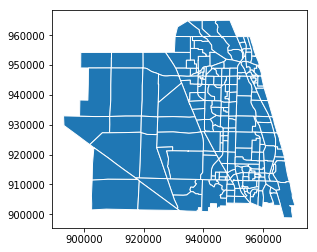

In [13]:
ax = taz_jupiter.plot(edgecolor='w')

Because Jupiter is in the northwest corner of the SERPM region, 
only the south and west boundaries of the study area are relevant
in the selection definition.  Convenietly, just like other DataFrame
indexers, the ``cx`` indexer allows for one-sided slices.

In [14]:
taz_jupiter2 = taz.cx[xmin:, ymin:]
taz_jupiter2.equals(taz_jupiter)

True

One important note regarding the ``cx`` indexer is that it will 
select all features that are contained fully *or partially* in
the selection area.  To illustrate, we can construct a GeoDataFrame
consisting of the study area box, and draw it on a map of the 
selected zones.

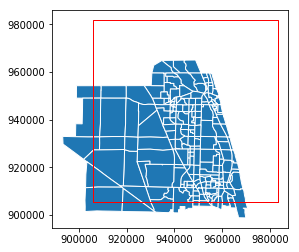

In [15]:
from shapely.geometry import box
study_area = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs={'init': 'epsg:2236'})
ax = taz_jupiter.plot(edgecolor='w')
transparent = (0,0,0,0)
ax = study_area.plot(ax=ax, edgecolor='red', facecolor=transparent)

### Selection by Polygon

If the study area is not neatly defined by a rectangle but instead by some
defined irregular polygon, it is still possible to filter the GeoDataFrame,
but slightly more complicated.  We'll demonstrate by first constructing
an irregular polygon.

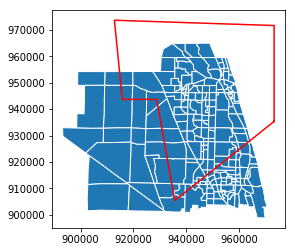

In [16]:
from shapely.geometry import Polygon
irregular_polygon = Polygon([
    (973346, 935343),
    (973346, 971695), 
    (912812, 973695), 
    (915812, 943695),  
    (928812, 943695),  
    (935712, 905343),  
])
ax = taz_jupiter.plot(edgecolor='w')
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

To indentify those TAZ polygons that touch the polygon, we can use the 
``intersects`` method of GeoDataFrames.

In [17]:
taz_jupiter.intersects(irregular_polygon)

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
755     False
756     False
1455    False
1462     True
1463     True
1464     True
1465     True
1466     True
1467    False
1468    False
1469    False
1491    False
1497     True
1498     True
1499     True
1500    False
1501    False
1631     True
1632    False
1635    False
1636     True
1637     True
1638     True
1639     True
1640     True
1641     True
1642     True
1643     True
1644     True
1645     True
Length: 220, dtype: bool

This gives us a series that matches the GeoDataFrame, and identifies whether
each row's geometry intersects the the polygon.  We can use that to filter
the rows, to retain only those TAZ's of interest.

In [18]:
taz_jupiter_irregular = taz_jupiter[taz_jupiter.intersects(irregular_polygon)]

In [19]:
len(taz_jupiter_irregular)

146

This gives us a new GeoDataFrame that is potentially just a filtered view of the 
original, which can potentially lead to problems later ([see here](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy)).  To ensure we have a
bonafide new GeoDataFrame, we can make sure it is a copy.

In [20]:
taz_jupiter_irregular = taz_jupiter_irregular.copy()

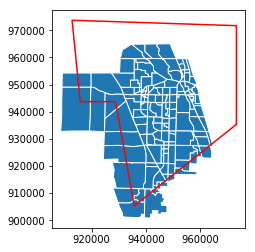

In [21]:
ax = taz_jupiter_irregular.plot(edgecolor='w')
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

You may note, as with the rectangular selection, we still select any 
zone that has any part of the zone inside the polygon.

## Clipping by Geography

If instead we want to actually clip the geographic data at the study area frame,
we can use the ``overlay`` function to get the intersection of the TAZ's and the
study area.

In [22]:
taz_jupiter_clip = gpd.overlay(taz, study_area, how='intersection')

By taking the intersection, we discard portions of the zone shapes that
are outside the study area, as is illustrated when we map the results
with the study area box.

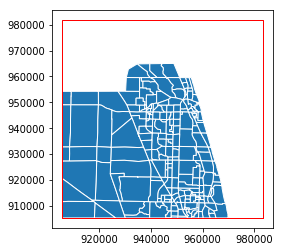

In [23]:
ax = taz_jupiter_clip.plot(edgecolor='w')
transparent = (0,0,0,0)
ax = study_area.plot(ax=ax, edgecolor='red', facecolor=transparent)

Alternatively, if we have a polygon, we can use ``intersection`` to trim the GeoDataFrame
geometry to only the overlapping areas.

In [24]:
taz_jupiter_irregular.geometry = taz_jupiter_irregular.intersection(irregular_polygon)

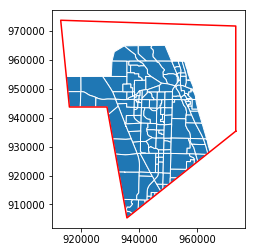

In [25]:
ax = taz_jupiter_irregular.plot(edgecolor='w')
transparent = (0,0,0,0)
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

An important feature to consider if using this method is that the operation
does not actually change the set of rows or any other data included in the 
GeoDataFrame.  If, for example, we apply it to the set of TAZ's from the square
clipped region, we can get a map that looks identical, but the GeoDataFrame will
still retain all the data rows from the previous version, just with some geometry
values set as empty.

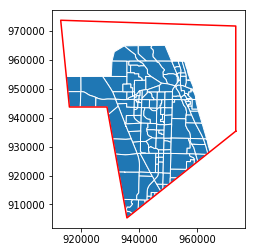

In [26]:
taz_jupiter_clip.geometry = taz_jupiter_clip.intersection(irregular_polygon)

ax = taz_jupiter_clip.plot(edgecolor='w')
transparent = (0,0,0,0)
lines = ax.plot(*irregular_polygon.exterior.xy, color='r')

In [27]:
len(taz_jupiter_irregular), len(taz_jupiter_clip)

(146, 220)

In [28]:
sum(taz_jupiter_clip.geometry.area == 0)

74

## Joining by Geography

A common task in geographic analysis is joining two sets of geographic data 
together.  We actually did a simple version of this just above, when we joined
the TAZ data with the study area, although the study area had only a single polygon
and no other associated data, so the results are not particularly inspiring.

As a more sophisticated example, let's consider the micro-area zone (MAZ) system from 
SERPM8.  The MAZ are smaller zones nested inside TAZ's, used to provide a higher resolution of data, 
particularly for transit travel. Using the TAZ system is sometimes too coarse for 
this purpose, as it may be convenient to walk to a bus stop located on a TAZ boundary
only for some parts of the zone, while the walking from the far side of the
same TAZ to the bus stop might be unreasonably far.  

Like the TAZ system, the MAZ system for SERPM8 is given by a shape file, and is included
in the tutorial data, so we can load it in the same way.

In [29]:
mazshape_filename = tt.data('SERPM8-MAZSHAPE')
maz = gpd.read_file(mazshape_filename)

In [30]:
len(maz)

12022

In [31]:
maz.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,"POLYGON ((953970.4660769962 723936.0810402408,..."
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,"POLYGON ((908505.2801046632 635081.7738410756,..."
2,3,5349,9446.131753,4.007041e+06,92,923725,707062,"POLYGON ((922736.6374686621 708387.6918614879,..."
3,4,5350,21773.153739,2.487397e+07,571,908988,713484,"POLYGON ((908334.2374677472 715692.2628822401,..."
4,5,5351,17882.701416,1.963139e+07,451,909221,717493,"POLYGON ((911883.0187559947 719309.3261861578,..."


We can select only MAZ's in the study area in the same manner as we did for TAZ's.

In [32]:
maz_jupiter = maz.cx[xmin:xmax, ymin:ymax]

In [33]:
len(maz_jupiter)

361

To create a joined GeoDataFrame, we can use the same [``overlay``](http://geopandas.org/reference/geopandas.overlay.html) function we used to clip
the TAZ's, although we will intersect the TAZ and MAZ geometries.

In [34]:
maz_taz = gpd.overlay(maz_jupiter, taz_jupiter, how='intersection')

The joined GeoDataFrame has all the columns from both the MAZ and TAZ source data.  In cases
where both source tables have an identically named column (for example, "OBJECTID") then both 
columns are retained, and they are labeled with "\_1" and "\_2" suffixes.

In [35]:
maz_taz.head()

,OBJECTID_1,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,OBJECTID_2,TAZ_REG,TAZ_OLD05,...,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area,geometry
0,2389,7736,10592.846522,4.442490e+06,102,936259,957308,1,1122.0,1122,...,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06,"POLYGON ((936374.6744969971 959539.5675094873,..."
1,2390,7737,17396.297932,1.568938e+07,360,940102,950911,2,17.0,17,...,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07,"POLYGON ((942254.5000076629 952920.9373740703,..."
2,2390,7737,17396.297932,1.568938e+07,360,940102,950911,3,1123.0,1123,...,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((938316.2017819136 951630.5626582429,..."
3,2391,7738,18511.806088,1.405994e+07,323,937715,953796,3,1123.0,1123,...,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((938309.9170175791 952656.4848189875,..."
4,6329,11676,10422.047410,3.336191e+06,77,937781,950989,3,1123.0,1123,...,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07,"POLYGON ((938309.9170175791 952656.4848189875,..."


Because we know that the MAZ's are supposed to be nested within the TAZ's, we
would normally expect that the joined data would have exactly one row for each of the
361 MAZ's, and that some TAZ's would be duplicated.  However, that's not what has happened.

In [36]:
len(maz_taz)

564

### Managing Errors in Joining Spatial Data

The joined data has 564 new zones, 203 more than we expected.  There are two
reasons for this discrepancy, although both are a result of the two zone systems
being misaligned.

The first reason is related to the limits computer precision: some of the new 
zones are merely slivers of space that arise due to rounding errors on the
computer placement of vertices.  If we evaluate the area of the first 5 zones
in the joined data table, we see that one of the zones is only 1.878×10<sup>-3</sup> 
square feet, or about a quarter of a square inch.
Clearly, this isn't a real zone!

In [37]:
maz_taz.head().area

0    4.442490e+06
1    1.568938e+07
2    1.878210e-03
3    1.405994e+07
4    3.336191e+06
dtype: float64

The seconds reason that extra zones are found in this join is because the two
zone systems are not always carefully aligned by the analysts who originally drew 
the zones, particularly in areas that are not functionally important. 
For example, here are the boundaries for the TAZ and MAZ systems, superimposed over 
a map of the The Loxahatchee Club golf course in Jupiter.  

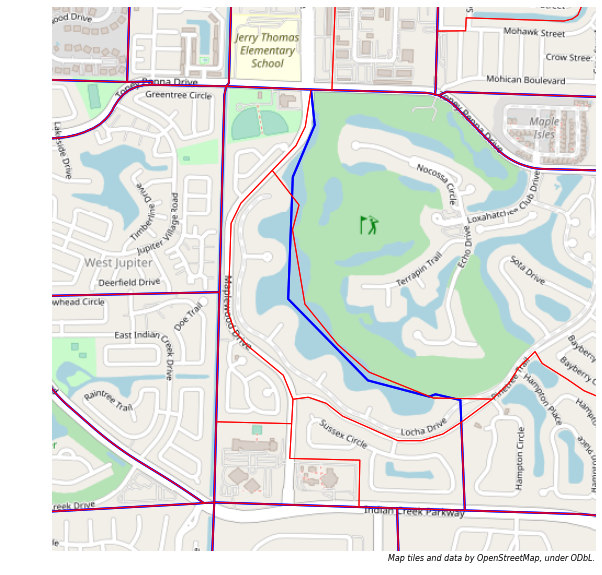

In [38]:
ax = tt.mapping.make_basemap(xlim=(938500,945500), ylim=(937500,944500), zoom=15, tiles='OSM_A', epsg=2236, axis='off')
ax = taz_jupiter.plot(ax=ax, edgecolor='blue', linewidth=2, facecolor=transparent )
ax = maz_jupiter.plot(ax=ax, edgecolor='red', linewidth=1, facecolor=transparent )

When the intersection of the two zone systems is computed, half a dozen extraneous small zones 
are generated along the lake that forms the western edge of the golf course, but these are not
actually meaningful activity locations and are not relevant for transortation analysis.

The possible solutions to both problems are the same, given that we know that the "correct" join solution
will have exactly one zone in the result for each MAZ.

#### Dropping Extra Pieces

One possible solution is to take the joined data we already have, and remove all 
the extra pieces of zones that were created, retaining only the largest main 
section of each MAZ.
To do this, we can sort zones in the joined GeoDataFrame by area, 
and retain only the largest zone from each group of duplicated MAZ codes.

First, we'll use the argsort method, to get the order of the joined zones, if ordered
by area.  Then we feed that into the ``iloc`` indexer to actually sort the rows as
indicated.  The argsort returns values in ascending order by default, so all the small
slivers and bits of zones we want to discard will appear first.

In [39]:
maz_taz = maz_taz.iloc[maz_taz.area.argsort()] 

Then, we can drop duplicate MAZ values from the table, keeping only the last instance
of each MAZ, which is the one we want.  In theory, if the two zones systems are very poorly
aligned, this process could drop the wrong part of the zones, although in almost all 
cases it will work fine.

In [40]:
maz_taz = maz_taz.drop_duplicates('MAZ', keep='last')

In [41]:
len(maz_taz)

361

One drawback of this method is that some small gaps may be left in the resulting
joined GeoDataFrame zones, in the spaces that are removed, as illustrated below.  
This may or may not be problematic, depending on the application.

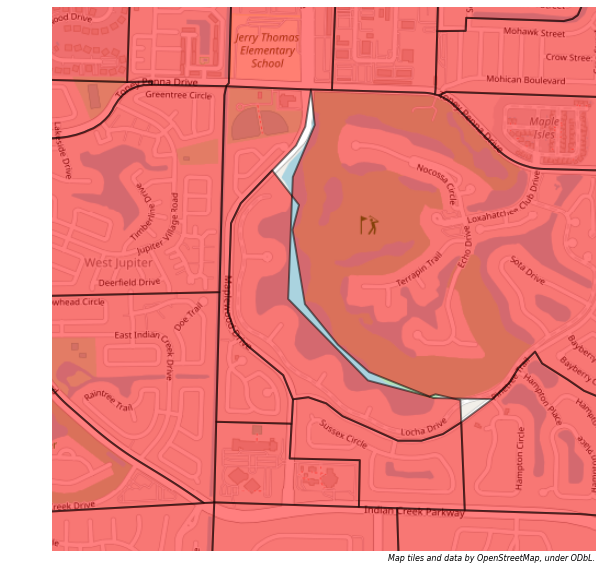

In [42]:
ax = tt.mapping.make_basemap(xlim=(938500,945500), ylim=(937500,944500), zoom=15, tiles='OSM_A', epsg=2236, axis='off')
ax = maz_taz.plot(ax=ax, edgecolor='k', linewidth=2, facecolor='r', alpha=0.5 )

#### Joining on Centroids

An alternate solution is to join the TAZ and MAZ data in a entirely different manner.
Rather than joining the two GeoDataFrames based on the area polygons in each, we
can join based on the area polygons for TAZ's and centroids for MAZ's.
To do this, we'll use the [sjoin](http://geopandas.org/reference/geopandas.sjoin.html)
method.

First, we'll need a version of the MAZ GeoDataFrame that has only centroid points
in the `geometry` column, instead of polygons.  To create this, start by making a copy of the
original data (assuming we want to save it for later).

In [43]:
maz_points = maz_jupiter.copy()

Then we want to change the geometry to be points instead of polygons.
(Both [Point](https://shapely.readthedocs.io/en/stable/manual.html#points) 
and [Polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) 
are specific object types in the shapely package that is used by GeoPandas.)
We could simply use the 'centroid' attribute of the geometry column to find new centroid 
for each zone, but in this data we already have X and Y values for a centroid,
so we'll prefer to use those.  We can uses the [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) method of DataFrames 
to create Point values, and assign those values into the geometry column.

In [44]:
from shapely.geometry import Point
maz_points.geometry = maz_points.apply(lambda x: Point(x.POINT_X, x.POINT_Y), axis=1)

Now we are ready to conduct a spatial join using the
[sjoin](http://geopandas.org/reference/geopandas.sjoin.html) function.
Like the overlay function, this function accepts two GeoDataFrames and returns
one, with general data columns from both inputs.  
Unlike the overlay function, the [sjoin](http://geopandas.org/reference/geopandas.sjoin.html) does not create any new geometries; 
instead, the resulting GeoDataFrame contains geometry from either
the left (first argument) or right (second argument) input GeoDataFrames.

In [45]:
sjoined = gpd.sjoin(maz_points, taz_jupiter, how='left', op='within')

In [46]:
len(sjoined)

361

In [47]:
sjoined.head()

,OBJECTID_left,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry,index_right,OBJECTID_right,...,COUNTY,CENSUSTAZ,TAZ_BF,FIX,AREA,F_NETAREA,CBD,HM_ROOMS,Shape_Leng,Shape_Area
2388,2389,7736,10592.846522,4.442490e+06,102,936259,957308,POINT (936259 957308),0,1,...,1.0,None,0,0,4442490.0,0.8153,0,0,10592.846522,4.442490e+06
2389,2390,7737,17396.297932,1.568938e+07,360,940102,950911,POINT (940102 950911),1,2,...,1.0,None,0,0,15689400.0,0.8571,0,0,17396.297932,1.568938e+07
2390,2391,7738,18511.806088,1.405994e+07,323,937715,953796,POINT (937715 953796),2,3,...,1.0,None,0,0,17396100.0,0.8663,0,0,23585.421941,1.739613e+07
2391,2392,7739,7202.864864,1.303422e+06,30,953218,953704,POINT (953218 953704),3,4,...,1.0,None,0,0,1303420.0,0.8536,0,0,7202.864864,1.303422e+06
2392,2393,7740,24940.959492,3.147748e+07,723,931973,952018,POINT (931973 952018),4,5,...,1.0,None,0,0,31477500.0,0.8787,0,0,24940.959492,3.147748e+07


The resulting GeoDataFrame has the geometry from the left input, which in this case is 
just the centroid points.

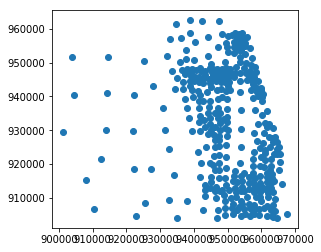

In [48]:
ax = sjoined.plot()

If we want to re-attach the polygon zones, we can do so easily if we didn't overwrite
the original MAZ data, because this joined data is in the same order as the original.

In [49]:
sjoined.MAZ.equals(maz_jupiter.MAZ)

True

In [50]:
sjoined.geometry = maz_jupiter.geometry

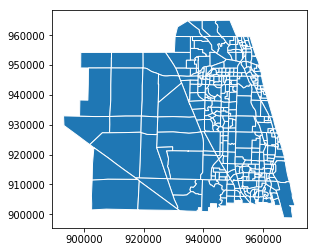

In [51]:
ax = sjoined.plot(edgecolor='w')

### Creating a Crosswalk Dictionary from the Joined Data

We will sometimes be given a MAZ id but want to get the TAZ id instead.  As this is
a one-to-many mapping (every MAZ is in one and only one TAZ, but each TAZ can contain
multiple MAZ's), it is convenient to express this mapping as a Python dictionary.
This can be done easily if the ``index`` of the GeoDataFrame is set to be the MAZ.

In [52]:
sjoined.index=sjoined.MAZ

In [53]:
maz_taz_crosswalk = dict(sjoined.TAZ_MPO)

Then, given a MAZ number we can access the TAZ simply like this:

In [54]:
maz_number = 7755
taz_number = maz_taz_crosswalk[maz_number]